📚 Import Required Libraries

In [ ]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Keras components
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [ ]:
# Fix random seed for reproducibility
np.random.seed(1000)

# Dimension of the noise vector (latent space)
random_dim = 100

📥 Load and Preprocess MNIST Dataset

In [ ]:
def load_mnist_data():
    # Load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()
    # Normalize pixel values from [0, 255] → [-1, 1]
    x_train = (x_train.astype(np.float32) / 127.5) - 1
    # Flatten 28x28 → 784 (vector form)
    x_train = x_train.reshape(60000, 784)
    return (x_train, _), (_, _)

🧑‍🎨 Define Generator Model

In [ ]:
def get_generator():
    generator = Sequential()

    # Input: random noise vector
    generator.add(Input(shape=(random_dim,)))
    generator.add(Dense(256, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    # Hidden layers
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    # Output layer: 784 (flattened 28x28 image), values in [-1, 1]
    generator.add(Dense(784, activation="tanh"))

    return generator

🕵️ Define Discriminator Model

In [ ]:
def get_discriminator():
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    discriminator = Sequential()

    # Input: flattened image vector (784)
    discriminator.add(Input(shape=(784,)))
    discriminator.add(
        Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02))
    )
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    # Hidden layers
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    # Output: probability of being real/fake
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(
        loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    return discriminator

🔗 Build Combined GAN Model

In [ ]:
def get_combined_model(discriminator, random_dim, generator):
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    # Freeze discriminator weights when training the generator
    discriminator.trainable = False

    # Input: noise vector → generator → fake image → discriminator
    z = Input(shape=(random_dim,))
    img = generator(z)
    validity = discriminator(img)

    # Combined model: trains generator to fool the discriminator
    combined_model = Model(inputs=z, outputs=validity)
    combined_model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return combined_model

🖼️ Helper Function: Plot Generated Images

In [ ]:
def plot_generated_images(
    epoch, generator, examples=100, dim=(10, 10), fig_size=(10, 10)
):
    # Sample noise
    noise = np.random.normal(loc=0, scale=1, size=(examples, random_dim))
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(examples, 28, 28)

    # Plot and save generated images
    plt.figure(figsize=fig_size)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        # Rescale [-1, 1] → [0, 255] for visualization
        img = (0.5 * generated_images[i] + 0.5) * 255
        img = img.astype(np.uint8)
        plt.imshow(img, interpolation="nearest", cmap="gray_r")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"vanilla_output/gan_generated_image_epoch_{epoch}.png")

🏋️ Training Function

In [ ]:
def train(epochs=1, batch_size=128, save_interval=20):
    # Load training data
    (x_train, _), (_, _) = load_mnist_data()

    # Initialize GAN components
    generator = get_generator()
    discriminator = get_discriminator()
    combined_model = get_combined_model(discriminator, random_dim, generator)

    # Labels: real=1 (smoothed to 0.9), fake=0
    valid = np.ones(shape=(batch_size, 1)) * 0.9
    fake = np.zeros(shape=(batch_size, 1))

    for epoch in range(1, epochs + 1):

        # -------------------------
        #  Train Discriminator
        # -------------------------

        # Sample a random batch of real images
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        imgs = x_train[idx]

        # Generate fake images
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, random_dim))
        gen_imgs = generator.predict(noise, verbose=0)

        # Train discriminator (real=1, fake=0)
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(x=imgs, y=valid)
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs, y=fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # -------------------------
        #  Train Generator
        # -------------------------

        # Train generator to fool the discriminator
        discriminator.trainable = False
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, random_dim))
        g_loss = combined_model.train_on_batch(x=noise, y=valid)

        # Print progress
        print(
            f"{epoch} [D loss: {d_loss[0]:.6f}, acc.: {d_loss[1]*100:.2f}%] "
            f"[G loss: {g_loss:.6f}]"
        )

        # Save models and generated samples at intervals
        if epoch == 1 or epoch % save_interval == 0:
            generator.save("vanilla_output/generator.keras")
            discriminator.save("vanilla_output/discriminator.keras")
            plot_generated_images(epoch, generator)

🚀 Train the Vanilla GAN

1 [D loss: 0.672270, acc.: 4.69%] [G loss: 0.688447]
2 [D loss: 0.596268, acc.: 5.96%] [G loss: 0.686090]
3 [D loss: 0.577393, acc.: 4.41%] [G loss: 0.685288]
4 [D loss: 0.564847, acc.: 3.79%] [G loss: 0.686041]
5 [D loss: 0.558153, acc.: 3.49%] [G loss: 0.686281]
6 [D loss: 0.552665, acc.: 3.68%] [G loss: 0.687541]
7 [D loss: 0.548630, acc.: 4.52%] [G loss: 0.689579]
8 [D loss: 0.545029, acc.: 5.89%] [G loss: 0.692808]
9 [D loss: 0.542015, acc.: 8.04%] [G loss: 0.696353]
10 [D loss: 0.539020, acc.: 10.62%] [G loss: 0.700475]
11 [D loss: 0.536108, acc.: 13.26%] [G loss: 0.705283]
12 [D loss: 0.533456, acc.: 15.99%] [G loss: 0.710118]
13 [D loss: 0.530905, acc.: 18.49%] [G loss: 0.715218]
14 [D loss: 0.528466, acc.: 20.66%] [G loss: 0.720353]
15 [D loss: 0.526006, acc.: 22.61%] [G loss: 0.726737]
16 [D loss: 0.524397, acc.: 24.29%] [G loss: 0.729574]
17 [D loss: 0.523185, acc.: 25.76%] [G loss: 0.735309]
18 [D loss: 0.529256, acc.: 25.96%] [G loss: 0.731709]
19 [D loss: 0.534165, acc.: 

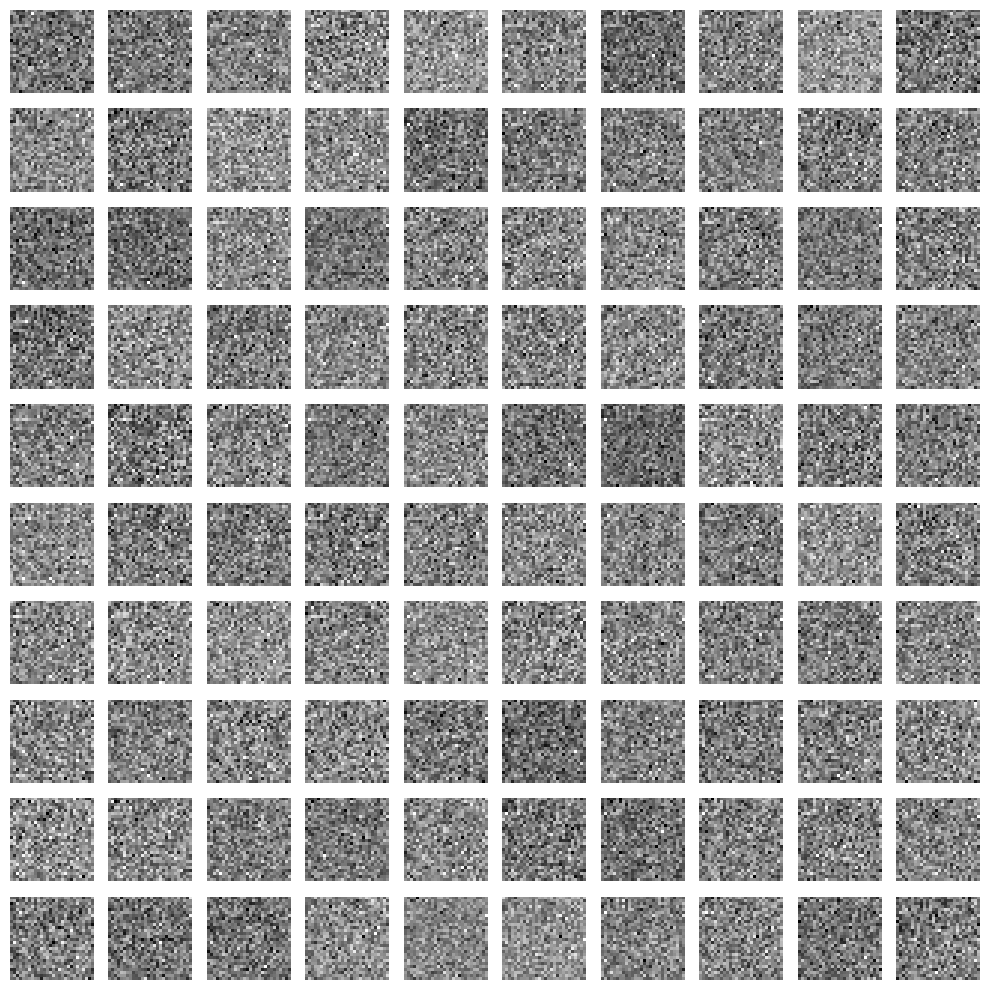

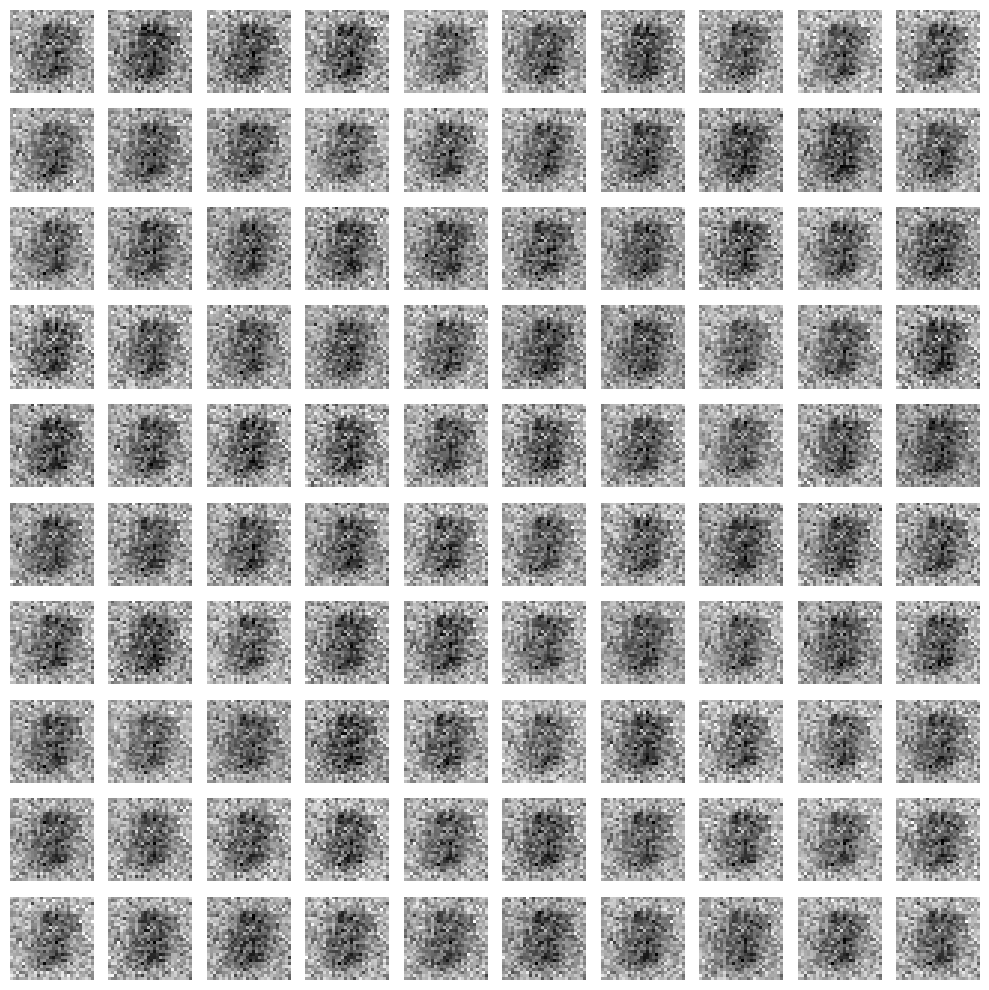

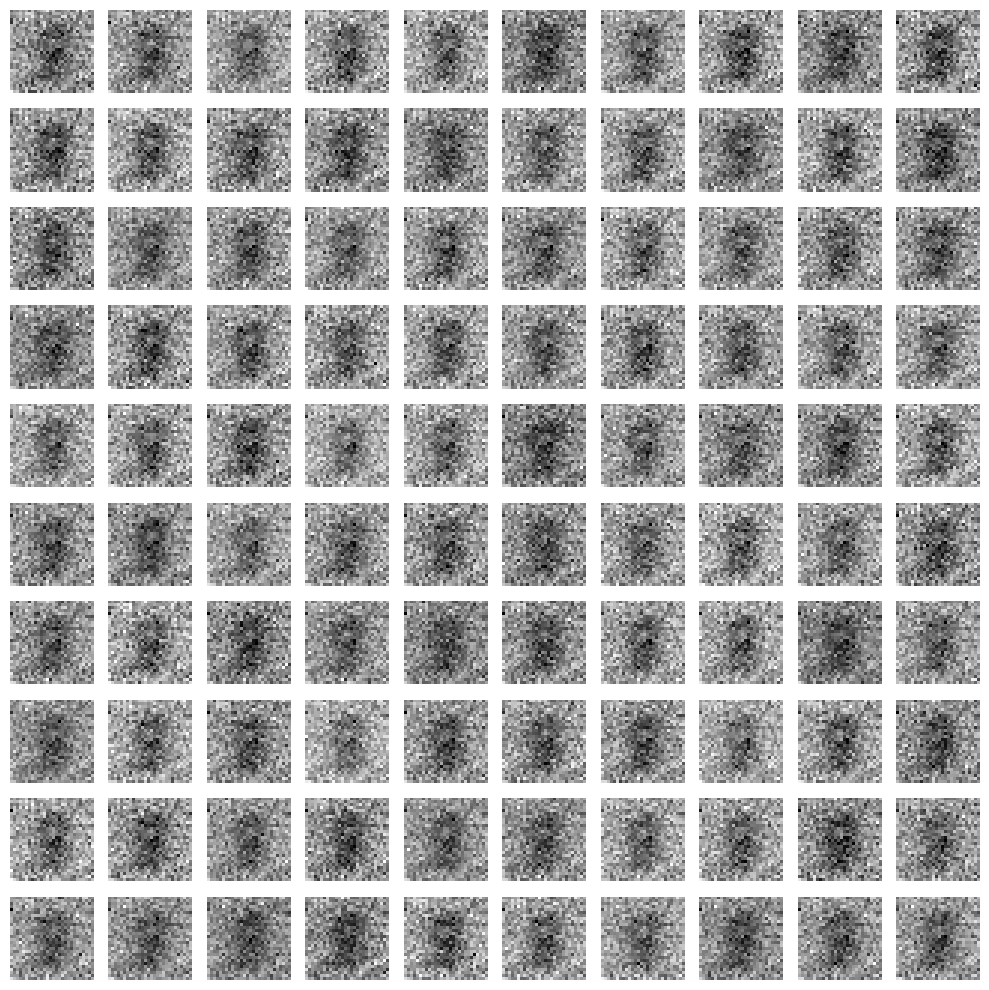

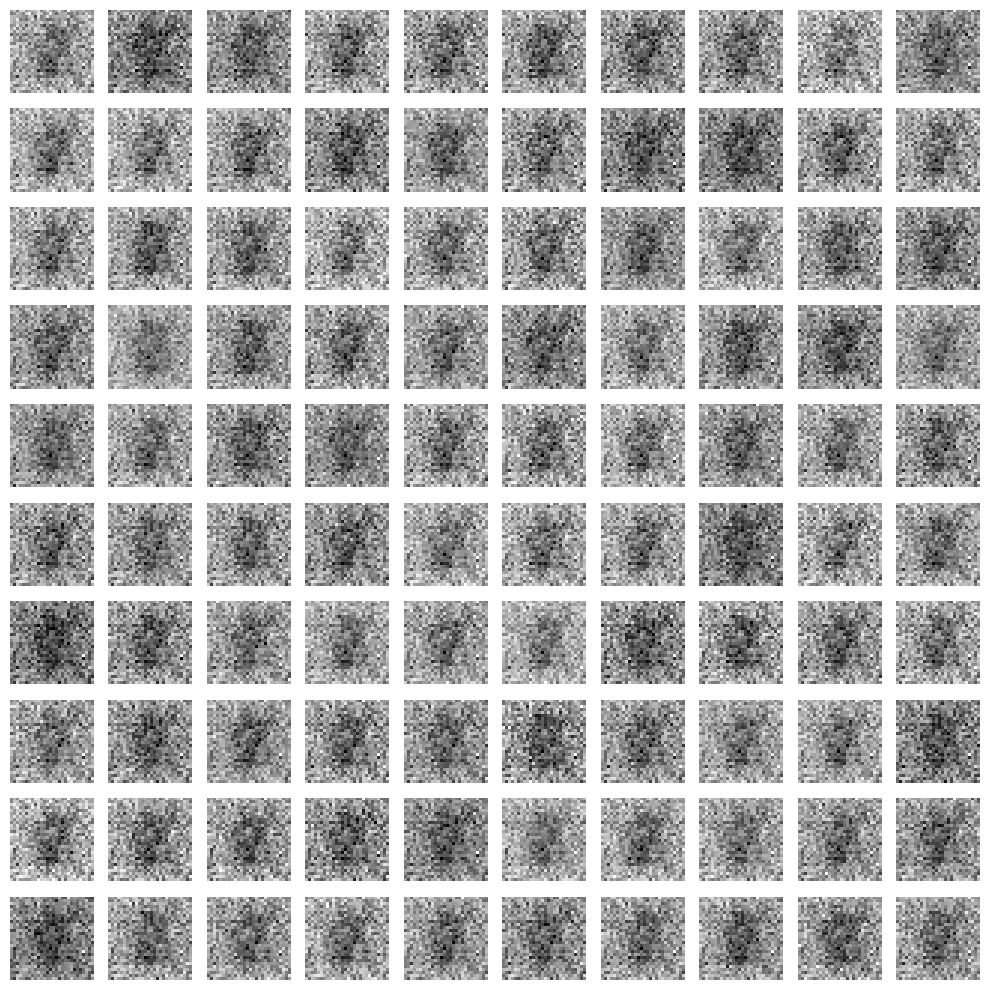

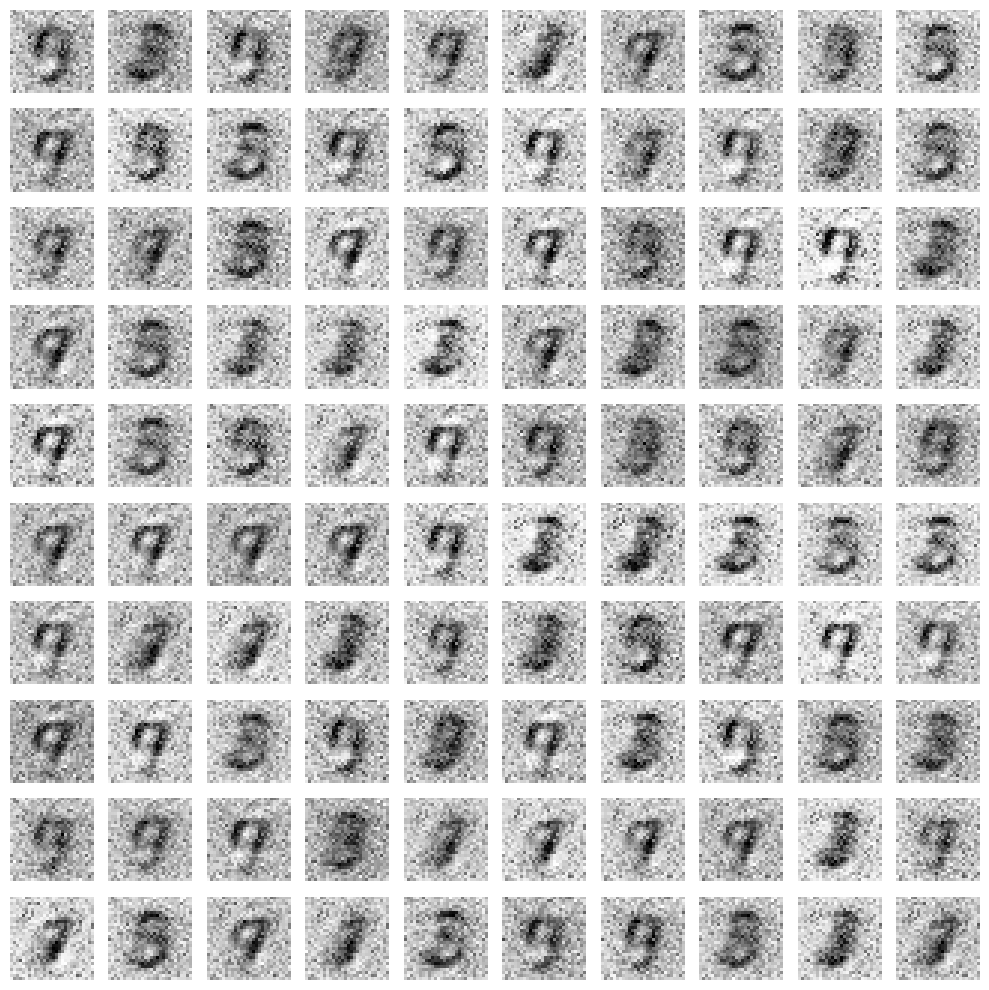

In [ ]:
train(epochs=200, save_interval=50)